## Classifying a phase transition in the XXZ model

In [1]:
import numpy as np

import time
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
from copy import copy, deepcopy

import sys
sys.path.append("..")

import Entangler
import TensorNetwork
import hamiltonians
import uuid
import json

import pennylane as qml
import pennylane.numpy as np

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

/tmp/ipykernel_10217/1398671730.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cuda = False

In [3]:
n_qubits = 10
wire = list(range(n_qubits))
depth = 4
depth_classifier = 6

ent = Entangler.IsingEntangler()
TN = TensorNetwork.Checkerboard(wire, ent, depth=depth)

TN_classifier = TensorNetwork.Checkerboard(wire, ent, depth=depth_classifier)

n_max = 100 # n_max = TN.n_params

### Loading the data

The data set contains the rows where first 100 are the parameters, then the Jz parameter, energy, and label

In [4]:
small_data = "vqe_2024-02-19_12-29-18.csv"
#bigger_data = "vqe_2024-02-18_18-50-31.csv"
#gpu_data = "vqe_GPU_2019-05-28_13-28-07.csv"
filename = small_data


df_vqe_2 = pd.read_csv(filename, header=None)
df_vqe_2 = df_vqe_2.map(lambda x: complex(x))

df_vqe_2[n_max] = df_vqe_2[n_max].apply(lambda x: x.real)
df_vqe_2[n_max+1] = df_vqe_2[n_max+1].apply(lambda x: x.real)
df_vqe_2[n_max+2] = df_vqe_2[n_max+2].apply(lambda x: x.real)

# df_vqe = df_vqe_2.drop([0, 1])
df_vqe = df_vqe_2

### Cleaning the data

In [5]:
df_vqe_clean = df_vqe.sort_values(by=[n_max])
df_vqe_clean.index = np.arange(len(df_vqe))
# df_vqe_clean = df_vqe.sort_index(by=[n_max])

todrop = []
tokeep = []
for i in range(len(df_vqe) // 2):
    E_1 = df_vqe_clean.iloc[i * 2, n_max + 1]
    E_2 = df_vqe_clean.iloc[i * 2 + 1, n_max + 1]
    h_1 = df_vqe_clean.iloc[i * 2, n_max]
    h_2 = df_vqe_clean.iloc[i * 2 + 1, n_max]

    if (E_2 > E_1):
        todrop.append(i * 2 + 1)
        tokeep.append(i * 2)
    else:
        todrop.append(i * 2)
        tokeep.append(i * 2 + 1)

        
for i in range(len(df_vqe) // 2):
    E_kept = df_vqe_clean.iloc[tokeep[i], n_max + 1]
    E_dropped = df_vqe_clean.iloc[todrop[i], n_max + 1]
    if E_dropped < E_kept:
        print("AAA")

print(df_vqe_clean.iloc[:20, [n_max, n_max + 1]])

print(todrop[:10])
print(tokeep[:10])

print("=============")        
        
df_vqe_clean = df_vqe_clean.drop(todrop)
print(df_vqe_clean.iloc[:10, [n_max, n_max + 1]])

     100        101
0   0.00 -12.437708
1   0.00 -12.438302
2   0.02 -12.513859
3   0.02 -12.535575
4   0.04 -12.611746
5   0.04 -12.589815
6   0.06 -12.667098
7   0.06 -12.687944
8   0.08 -12.765143
9   0.08 -12.744831
10  0.10 -12.823273
11  0.10 -12.841849
12  0.12 -12.920228
13  0.12 -12.902485
14  0.14 -12.982204
15  0.14 -12.997663
16  0.16 -13.076787
17  0.16 -13.062887
18  0.18 -13.144181
19  0.18 -13.155852
[0, 2, 5, 6, 9, 10, 13, 14, 17, 18]
[1, 3, 4, 7, 8, 11, 12, 15, 16, 19]
     100        101
1   0.00 -12.438302
3   0.02 -12.535575
4   0.04 -12.611746
7   0.06 -12.687944
8   0.08 -12.765143
11  0.10 -12.841849
12  0.12 -12.920228
15  0.14 -12.997663
16  0.16 -13.076787
19  0.18 -13.155852


In [6]:
len(df_vqe_clean)

100

### Augmenting the data

#### Flips

The XXZ model has symmetry with respect to rotations
in the xy plane, as well as spin-flip symmetry. I will augment data by flipping the spins along the X direction.

In [7]:
df_flip = df_vqe_clean.copy()

df_flip.index = np.arange(len(df_flip))


In [8]:
## hardcoded for 10 qubits and depth 4
z_gate_indices = [74 + i * 5 + k for i in range(5) for k in (4, 5)]
x_gate_indices = [74 + i * 5 + k for i in range(5) for k in (1, 2)]


In [9]:
for n in z_gate_indices:
    df_flip[n] *= -1

for n in x_gate_indices:
    df_flip[n] += np.pi


To check the correctness of the flip operation, I will now check that the ansatz parameters and the energy are consistent

In [10]:
h_0 = hamiltonians.xxz_heisenberg_model(10, 1, 0)
h_1 = hamiltonians.xxz_heisenberg_model(10, 0, 1)
H_0 = hamiltonians.explicit_hamiltonian(h_0)
H_1 = hamiltonians.explicit_hamiltonian(h_1)

energy_off = False
statebuilding_error = False

for i, row in df_flip.iterrows():
    if i>50:
        break
            
    E = row[n_max + 1].real
    h = row[n_max].real
    H = H_0 + h * H_1
    H_op  = qml.Hermitian(H, wire)
    
    dev1 = qml.device("default.qubit",wire)
    @qml.qnode(dev1)
    def test_energy(params):
        TN.construct_circuit(params) # build the ground state, embed the train data
        return qml.expval(H_op)
            
    E_fact = test_energy(np.array(row[:n_max]))        
              
    if not(np.isclose(E, E_fact)):
        print("Found energy error in row {}".format(i))
        energy_off = True
        
    

        
if (not energy_off):
    print("All OK")

All OK


In [12]:
df_with_flip = pd.concat([df_vqe_clean,df_flip],ignore_index=True)

In [13]:
#df_with_flip = df_vqe_clean.append(df_flip)
len(df_with_flip)

200

### Reload the prepared dataset if you don't want to build it

In [14]:
### Load if necessary

#df_total = pd.read_csv("df_total_bigger.csv", header=None)
df_total = df_with_flip
df_total[n_max+2] = df_total[n_max+2].apply(lambda x: x*2-1) # transfer label to {-1,1}
print(len(df_total))


200


### Split the data into train and test

In [15]:
df_shuffled = df_total.sample(frac=1).reset_index(drop=True)
train_pos = int(0.8 * len(df_total))
df_train = df_shuffled.iloc[:train_pos,:]
df_test = df_shuffled.iloc[train_pos:,:]

df_train_data = np.array(df_train) # will cut of the last 3 elements in circuit
df_train_label = np.array(df_train[n_max+2])
df_test_data = np.array(df_test) # will cut of the last 3 elements in circuit
df_test_label = np.array(df_test[n_max+2])


### Constructing objective functions

In [16]:
if cuda == True:
    dev = qml.device("lightning.gpu",wire)
else:
    dev = qml.device("default.qubit",wire)
    
@qml.qnode(dev)
def circuit(params, weights):
    TN.construct_circuit(params) # build the ground state, embed the train data
    TN_classifier.construct_circuit(weights)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7)@qml.PauliZ(8)@qml.PauliZ(9))
    
def variational_classifier(weights, bias, params):
    return circuit(params[:n_max], weights) + bias

def loss_fn(labels, predictions):
    return sum((labels - predictions)**2)/len(labels)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, train_data, labels):
    predictions = [variational_classifier(weights, bias, params) for params in train_data]
    return loss_fn(labels, predictions)


### Running the machine learning

In [19]:
np.random.seed(0)

weights_init = 0.1 * np.random.randn(TN_classifier.n_params, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
opt = qml.NesterovMomentumOptimizer(0.5)
batch_size = 0.5*len(df_train_data)

In [20]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(df_train_label), (batch_size,))
    data_batch = df_train_data[batch_index]
    label_batch = df_train_label[batch_index]
    
    
    weights, bias = opt.step(cost, weights, bias, train_data=data_batch, labels=label_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, df)) for df in df_train_data]

    current_cost = cost(weights, bias, df_train_data, df_train_label)
    acc = accuracy(df_train_label, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    

Iter:    1 | Cost: 1.4210730 | Accuracy: 0.4687500
Iter:    2 | Cost: 1.0829849 | Accuracy: 0.4687500
Iter:    3 | Cost: 0.9851787 | Accuracy: 0.5312500
Iter:    4 | Cost: 0.8143432 | Accuracy: 0.8312500
Iter:    5 | Cost: 0.8620548 | Accuracy: 0.5312500
Iter:    6 | Cost: 0.9237712 | Accuracy: 0.5312500
Iter:    7 | Cost: 0.9490297 | Accuracy: 0.5312500
Iter:    8 | Cost: 0.9697790 | Accuracy: 0.4687500
Iter:    9 | Cost: 0.9427825 | Accuracy: 0.6562500
Iter:   10 | Cost: 1.0201577 | Accuracy: 0.4687500
Iter:   11 | Cost: 0.9681670 | Accuracy: 0.5312500
Iter:   12 | Cost: 0.8892342 | Accuracy: 0.5312500
Iter:   13 | Cost: 0.8047212 | Accuracy: 0.8312500
Iter:   14 | Cost: 0.7128231 | Accuracy: 0.9062500
Iter:   15 | Cost: 0.6520568 | Accuracy: 0.9062500
Iter:   16 | Cost: 0.6058706 | Accuracy: 0.9062500
Iter:   17 | Cost: 0.6512495 | Accuracy: 0.8812500
Iter:   18 | Cost: 0.5944283 | Accuracy: 0.9062500
Iter:   19 | Cost: 0.6670683 | Accuracy: 0.9500000
Iter:   20 | Cost: 0.6461805 | 

### Checking the performance on the test set

In [22]:
predictions_test = [np.sign(variational_classifier(weights, bias, df)) for df in df_test_data]

acc_test = accuracy(df_test_label, predictions_test)

print("Accuracy on test data:", acc_test)

Accuracy on test data: 1.0


In [23]:

%matplotlib inline

preds = []
trues = np.array(df_total[n_max + 2])
for i in range(len(df_total)):
    params = df_total.iloc[i][:n_max]
    preds.append(variational_classifier(weights, bias, params))
    
    

# plt.rcParams.update({'font.size': 14})


# plt.figure()
# fields = np.array(df_test[n_max])
# plt.scatter(fields, preds)

# plt.xlabel(r'$J_z$')
# plt.ylabel('Prediction of label II')
# plt.grid()
# plt.ylim([0, 1])
# plt.xlim([0, 2])
# plt.plot([1, 1], [0, 1], 'r')
# plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
# plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
# plt.plot([0, 2], [0.5, 0.5], 'r--')
# plt.show()

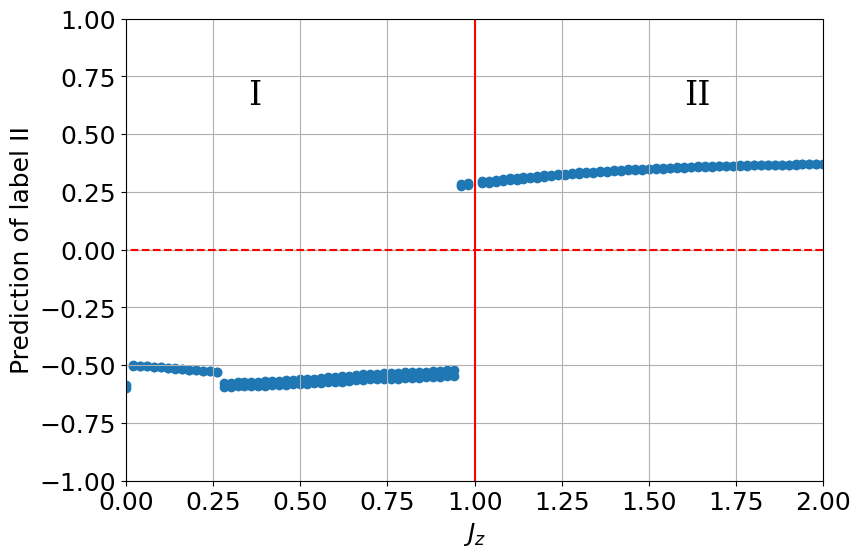

In [24]:

# %matplotlib inline
# plt.rcParams.update({'font.size': 14})
# plt.figure()
fields = np.array(df_total[n_max])
plt.scatter(fields, preds)

plt.xlabel(r'$J_z$')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([-1, 1])
plt.xlim([0, 2])
plt.plot([1, 1], [-1, 1], 'r')
plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
plt.plot([2, 0], [0,0], 'r--')
plt.show()